# **TAREA 2a (Teoría)**
Estimación temporal: 1 hora

**Ejercicio 1:** Además de los filtros estocásticos vistos (Kalman y Partículas), hay otros como State-Space Kalman Filter, Wiener Filter o Extended Kalman Particle Filter. Buscar información sobre uno de ellos (definición, aplicaciones, etc), buscar un código de ejemplo y comentar paso a paso el código para demostrar que se ha comprendido correctamente.

**Respuesta**
Los filtros estocásticos sirven para operar sobre aquellos datos que tienen algún tipo de ruido.
Voy a implementar el filtro de Wiener el cual es utilizado para la estimación de señales en presencia de ruido. Este filtro minimiza la suma del error cuadrático entre la señal original y la estimada.  El Filtro de Wiener opera en el dominio de la frecuencia, por lo que se realiza la transformada de Fourier

In [27]:
#codigo
import numpy as np
import matplotlib.pyplot as plt

def wiener_filter(signal, noise_variance):
    """
    Aplica el filtro de Wiener a una señal en presencia de ruido.

    Parámetros:
    - signal: Señal original + ruido.
    - noise_variance: Varianza del ruido presente en la señal.

    Retorna:
    - Señal filtrada.
    """
    # Transformada de Fourier de la señal
    signal_fft = np.fft.fft(signal)

    # Potencia de la señal
    signal_power = np.abs(signal_fft) ** 2

    # Cálculo del filtro de Wiener en el dominio de la frecuencia
    wiener_filter = signal_power / (signal_power + noise_variance)

    # Aplicación del filtro de Wiener
    filtered_fft = signal_fft * wiener_filter

    # Transformada inversa de Fourier para obtener la señal filtrada
    filtered_signal = np.fft.ifft(filtered_fft).real

    return filtered_signal


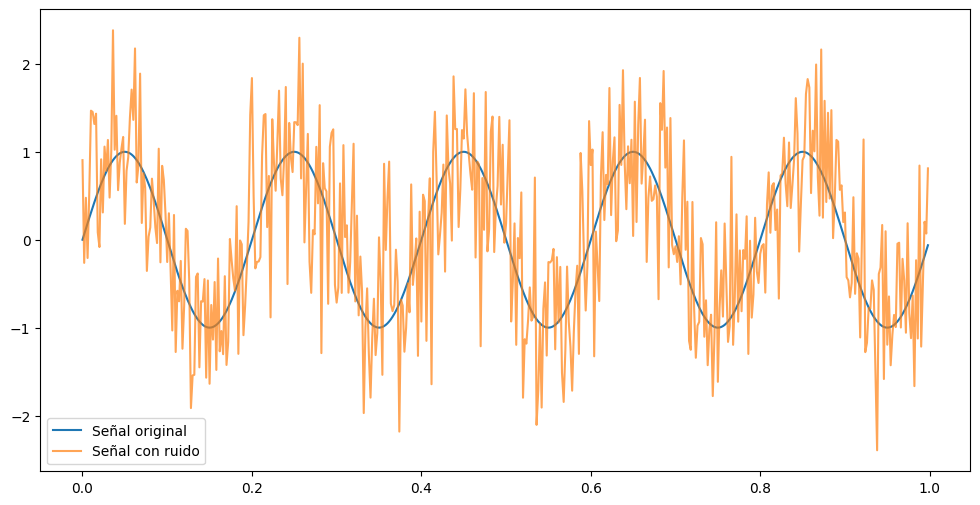

In [35]:
# Parámetros
fs = 500  # Frecuencia de muestreo
t = np.arange(0, 1.0, 1.0/fs)  # Vector de tiempo
f = 5  # Frecuencia de la señal
noise_variance = 0.5  # Varianza del ruido

# Señal original (sin ruido)
original_signal = np.sin(2 * np.pi * f * t)

# Señal con ruido 
noisy_signal = original_signal + np.sqrt(noise_variance) * np.random.randn(t.size)

# Visualizar señal original y señal con ruido
plt.figure(figsize=(12, 6))
plt.plot(t, original_signal, label="Señal original")
plt.plot(t, noisy_signal, label="Señal con ruido", alpha=0.7)
plt.legend()
plt.show()


0.5


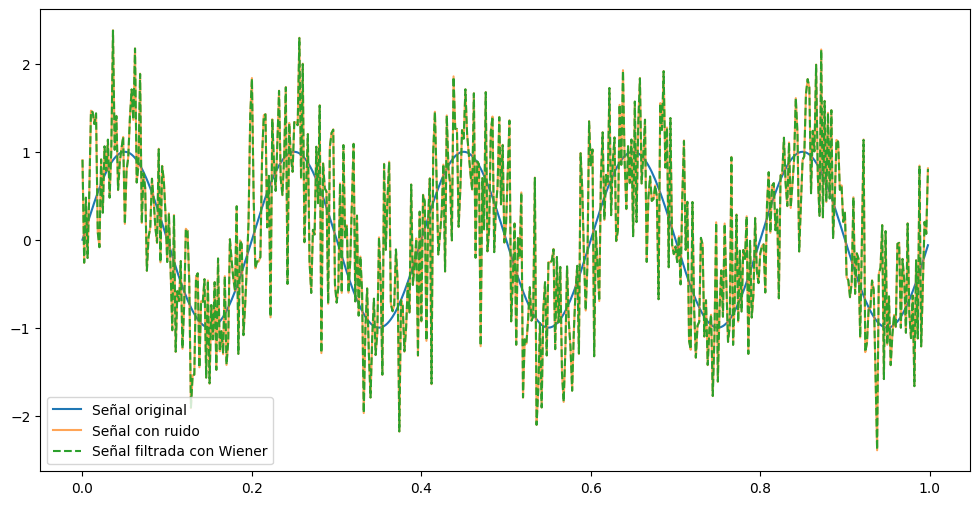

In [36]:
# Aplicar el filtro de Wiener
# print(noisy_signal)
print(noise_variance)
filtered_signal = wiener_filter(noisy_signal, noise_variance)

# Visualizar la señal filtrada
plt.figure(figsize=(12, 6))
plt.plot(t, original_signal, label="Señal original")
plt.plot(t, noisy_signal, label="Señal con ruido", alpha=0.7)
plt.plot(t, filtered_signal, label="Señal filtrada con Wiener", linestyle='dashed')
plt.legend()
plt.show()


Si noise_variance es pequeño en comparación con signal_power: El valor del filtro de Wiener se acerca a 1. Esto significa que estamos "confiando" más en la señal ruidosa, ya que asumimos que el ruido es insignificante. Como resultado, la señal filtrada se parecerá mucho a la señal ruidosa.
Si noise_variance es grande en comparación con signal_power: El valor del filtro de Wiener se acerca a 0 en las frecuencias donde la potencia de la señal es baja. Esto significa que estamos "confiando" menos en la señal ruidosa y más en nuestra suposición sobre el ruido

**Ejercicio 2:** Aplicar uno de los dos filtros base (Kalman o Partículas) en el ejemplo anterior y comparar.

In [37]:
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, initial_state, initial_estimate_error):
        # Varianzas
        self.process_variance = process_variance  # Varianza del proceso (Q)
        self.measurement_variance = measurement_variance  # Varianza de la medición (R)

        # Estado inicial y error de estimación inicial
        self.state = initial_state  # Estado estimado (x)
        self.estimate_error = initial_estimate_error  # Error de estimación (P)

        # Modelo de observación (H) y matriz de transición (A)
        self.H = np.eye(len(initial_state))
        self.A = np.eye(len(initial_state))

    def predict(self):
        # Predicción del estado y de la matriz de covarianza
        self.state = np.dot(self.A, self.state)
        self.estimate_error = np.dot(np.dot(self.A, self.estimate_error), self.A.T) + self.process_variance

    def update(self, measurement):
        # Cálculo de la ganancia de Kalman (K)
        K = np.dot(np.dot(self.estimate_error, self.H.T), np.linalg.inv(np.dot(np.dot(self.H, self.estimate_error), self.H.T) + self.measurement_variance))

        # Actualización del estado y de la matriz de covarianza
        self.state = self.state + np.dot(K, measurement - np.dot(self.H, self.state))
        self.estimate_error = np.dot(np.eye(len(self.state)) - np.dot(K, self.H), self.estimate_error)

        return self.state


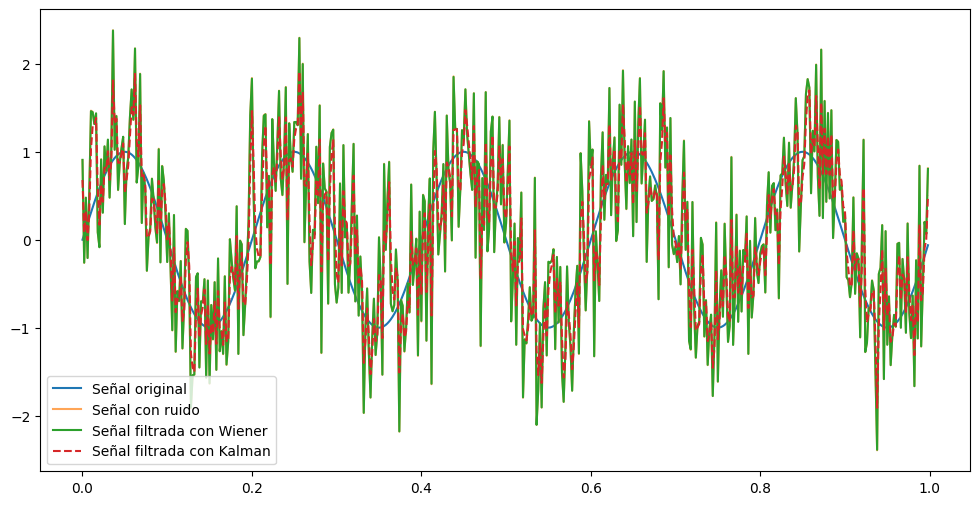

In [42]:
# Inicializar el Filtro de Kalman
# Establecemos que no tenemos conocimiento previo de la señal
initial_state = np.array([0, 0])  
# Matriz de covarianza inicial
initial_estimate_error = np.eye(2)  

kf = KalmanFilter(process_variance=np.eye(2) * noise_variance, 
                  measurement_variance=np.eye(2) * noise_variance, 
                  initial_state=initial_state, 
                  initial_estimate_error=initial_estimate_error)

# Aplicar el Filtro de Kalman a la señal ruidosa como he usado el ejemplo de teoria hay que hacerlo de la siguiente manera
kalman_filtered = []
for measurement in noisy_signal:
    kf.predict()
    estimated_state = kf.update(np.array([measurement, measurement]))  # Usamos una observación 2D para coincidir con la dimensión del estado
    kalman_filtered.append(estimated_state[0])  # Tomamos la primera componente del estado estimado

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(t, original_signal, label="Señal original")
plt.plot(t, noisy_signal, label="Señal con ruido", alpha=0.7)
plt.plot(t, filtered_signal, label="Señal filtrada con Wiener")
plt.plot(t, kalman_filtered, label="Señal filtrada con Kalman", linestyle='dashed')

plt.legend()
plt.show()


La principal diferencia entre ambos filtros implementados es que Kalman tiene naturaleza dinámica lo que quiere decir que es un filtro recursivo que opera en tiempo real. Se adapta y cambia con cada nueva observación, haciendo predicciones y actualizaciones basadas en un modelo de sistema y las observaciones actuales. Al contrario de filtro de Wiener que es de naturaleza estática al ser un filtro lineal y estacionario, lo que significa que no cambia con el tiempo ni con las condiciones

**Ejercicio 3:** Ejecuta y estudia el código siguiente (muestreo) y coméntalo. ¿Qué técnica es?

In [43]:
!pip install torch-geometric


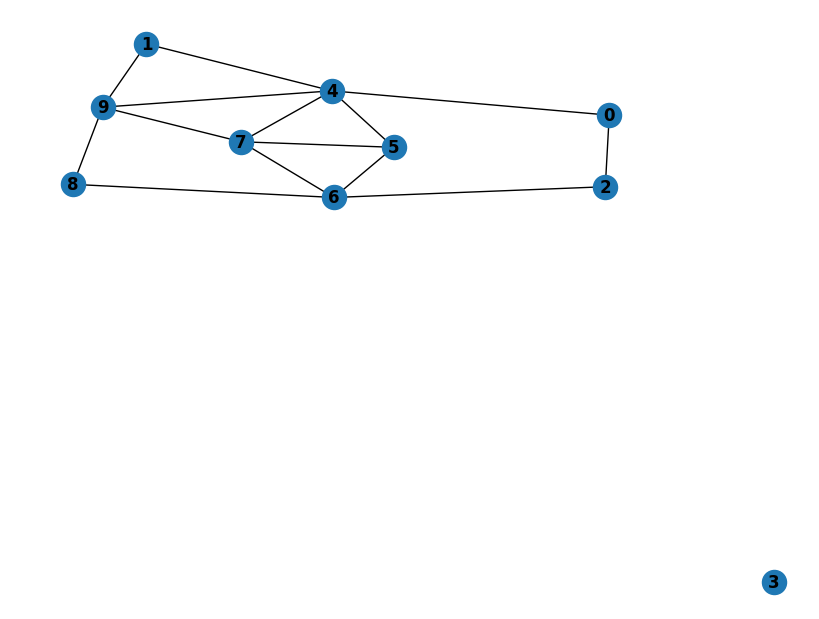

In [44]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, from_networkx

# ...
graph = nx.erdos_renyi_graph(10, 0.4)

# ...
data = from_networkx(graph)

# ...
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__() # ...
        self.conv = torch_geometric.nn.GCNConv(data.num_features, data.num_features) # ...

    def forward(self, x, edge_index): # ...
        return self.conv(x, edge_index) # ...

model = GNNModel() # ...

# ...
def energy(graph):
    data = from_networkx(graph) # ...
    x = torch.randn(data.num_nodes, data.num_features)  # ...
    edge_index = data.edge_index # ...
    logits = model(x, edge_index)  # ...
    return -torch.sum(logits)  # ...

# ...
def tecnicaSuperSecreta(graph, proposal_graph):
    # ...
    energy_before = energy(graph) # ...
    energy_after = energy(proposal_graph) # ...

    # ...
    acceptance_ratio = torch.exp(energy_before - energy_after)

    # ...
    if torch.rand(1) < acceptance_ratio:
        return proposal_graph
    else:
        return graph

# ...
num_iterations = 1000
for _ in range(num_iterations):
    # ...
    proposal_graph = nx.erdos_renyi_graph(10, 0.4)

    # ...
    graph = tecnicaSuperSecreta(graph, proposal_graph)

# ...
plt.figure(figsize=(8, 6))
nx.draw(graph, with_labels=True, font_weight='bold')
plt.show()


El código presentado utiliza técnicas relacionadas con las redes neuronales gráficas (GNN) y el muestreo Metropolis-Hastings.

In [ ]:
# Explicacion del codigo por partes
# Creación del grafo 
graph = nx.erdos_renyi_graph(10, 0.4)
# Conversión de NetworkX a Torch Geometric:
data = from_networkx(graph)

El código implementa una técnica de muestreo Metropolis-Hastings aplicada a grafos, utilizando una red neuronal gráfica (GNN) para calcular una "energía" asociada a cada grafo. El algoritmo de Metropolis-Hastings se utiliza comúnmente en estadísticas para obtener una secuencia de muestras aleatorias a partir de una distribución de probabilidad compleja. En este caso, se usa para explorar el espacio de posibles grafos y seleccionar aquellos con energías deseables.

**Propagación de creencias (Belief Propagation - BP).**

Fuente: https://jessicastringham.net/2019/01/09/sum-product-message-passing/


Junto a la Cadena de Markov Monte Carlo (MCMC), el algoritmo de propagación de creencias (BP) es uno de los más populares para realizar inferencia computacional.

Esta inferencia en sistemas estocásticos implica predecir eventos futuros o estimar estados no observados, algo realmente útil en problemas como el pronóstico del clima, donde las condiciones futuras son inciertas y deben estimarse a partir de datos históricos y modelos estocásticos.

Como hemos estudiado, MCMC es un método probabilístico exacto que, sin embargo, a menudo es realmente lento. Por el contrario, la técnica de propagación de creencias es un método determinista rápido, empíricamente muy exitoso, pero que en situaciones de bucles puede reducir su eficacia.

Su funcionamiento es muy sencillo: se pretende realizar consultas para identificar como varia la distribución de probabilidad dada nueva información, actualizando la probabilidad de las variables en función de estas nuevas observaciones.
Esta nueva información (o evidencia) permite dos clasificaciones:


*   Hard evidence: se especifican nuevos valores sobre variables de la red.
*   Soft evidence: se especifica una nueva distribución de probabilidad para una o varias variables de la red.


Al ser un algoritmo muy estudiando, hay multitud de variaciones y clasificaciones en función de las necesidades concretas del problema a tratar, como algoritmos de inferencia exacta (cálculo de probabilidad exacta por repetición) o aproximada (estimación de valores aproximados de la probabilidad para un muestreo global).

También se distinguen entre versiones del algoritmo en función del tipo de consulta, como consultas de probabilidad condicional (CPQ) o consultas de máximo a posteriori (MAP).



**Ejercicio 4:** ¿Cuándo se usan las consultas de probabilidad condicional (CPQ) y las consultas de máximo a posteriori (MAP)?

**Respuesta ejercicio 4**
Las consultas de probabilidad condicional (CPQ) y las consultas de máximo a posteriori (MAP) son dos tipos de consultas que se pueden realizar en el contexto de la inferencia probabilística. 
**CPQ:** diseñada para calcular la distribución de probabilidad de un conjunto de variables dadas algunas evidencias observadas. Se busca responder preguntas del tipo:  **"¿Cuál es la probabilidad de que la variable X tome el valor x dado que se ha observado la evidencia E?"**
Se utilizan cuando se quiere obtener una distribución completa de probabilidades para las variables de interés, en lugar de simplemente la configuración más probable.

**MAP:** busca la asignación de variables que es más probable dada la evidencia.
Se usan cuando se busca una respuesta determinista basada en la evidencia y el modelo probabilístico.

**Ejercicio 5:** Explicar cómo funcionan las técnicas LS Message Passing, Logic Sampling y Likelihood Weighting (opcional: explicarlo sobre código)

**Respuesta pregunta 5**

**LS Message Passing**:Técnica es una variante del algoritmo de Propagación de Creencias (BP) para grafos que contienen ciclos o bucles. Funciona de manera que los nodos vecinos conectados entre ellos se envían mensajes a lo largo de las iteraciones hasta llegar a un consenso.

**Logic Sampling**: técnica de muestreo que genera muestras aleatorias de una red Bayesiana.Se comienza en un nodo raíz de la red y se toma una muestra de su distribución prior. Para cada nodo hijo, se muestrea su distribución condicional basada en el valor muestreado de su nodo padre. Se repite el proceso hasta que se han muestreado todos los nodos. Y luego se vuelve a repetir todo otra vez.

**Likelihood Weighting**: genera muestras de las variables no observadas de una red Bayesiana, teniendo en cuenta cada muestra por la probabilidad de las variables que ya se han observado.  Comienza muestreando desde los nodos raíz, cuando se encuentra con una variable que tiene evidencia observada, se fija su valor al valor observado y se calcula un peso para la muestra basado en la probabilidad de ese valor observado. El proceso continúa muestreando las variables restantes y ajustando el peso según los ya observados
Al final, se obtienen muestras de las variables no observadas con pesos asociados que reflejan la probabilidad de las observaciones.

**PROBABILIDAD**

**Ejercicio 6:** ¿En los siguientes enunciados de problemas de probabilidad, qué media usarias? (No hay que resolver los ejercicios...)



*   Si el precio de una jeringuilla ha aumentado progresivamente en los últimos 4 años un 10%, 20%, 30% y 40%, ¿cuál es la media del encarecimiento por año?
*   Para controlar la temperatura de un paciente, la primera hora ha tenido 37 grados, las siguientes dos horas 41 grados, y la cuarta hora 36 grados. ¿Cuál es la media de las temperaturas?
*   Si hemos comprado 10 vacunas de Pfizer a 5 euros cada una, 7 vacunas de Moderna a 11 euros cada una y  3 vacunas de Astrazeneca a 0.5 euros cada una, ¿cuál es el precio medio de una vacuna?
*   Calcular la duración media (semanas) de un esguince de tobillo, tomando como muestra los siguientes 5 pacientes: 7, 3, 9, 4, 6 (semanas).

**Respuesta pregunta 6**
1.  Media a utilizar: Media aritmética.
    Razón: Estamos interesados en el encarecimiento promedio a lo largo de un período fijo (4 años), y cada año tiene igual importancia en 
el cálculo.
2.  Media a utilizar: Media ponderada.
    Razón: Cada temperatura no se mantiene durante el mismo período de tiempo. Por ejemplo, 41 grados se mantiene durante dos horas, 
mientras que las otras temperaturas solo duran una hora. Por lo tanto, algunas temperaturas tienen más "peso" que otras en el cálculo.
3.  Media a utilizar: Media ponderada.
    Razón: Al igual que en el segundo ejemplo, no todas las vacunas tienen el mismo precio, y hemos comprado diferentes cantidades de cada una. Por lo tanto, algunas vacunas (y sus respectivos precios) tienen más influencia en el cálculo del precio promedio que otras.
4.  Media a utilizar: Media aritmética.
Razón: Cada paciente proporciona una única medida de la duración de su esguince, y todas estas duraciones tienen igual importancia para calcular la duración promedio.

**Función de masa de probabilidad (PMF)**

Esta función (Probability Mass Function en inglés) se usa para describir la distribución de probabilidad discreta de una variable aleatoria.

P(X = 3) = 0.16666666666666666


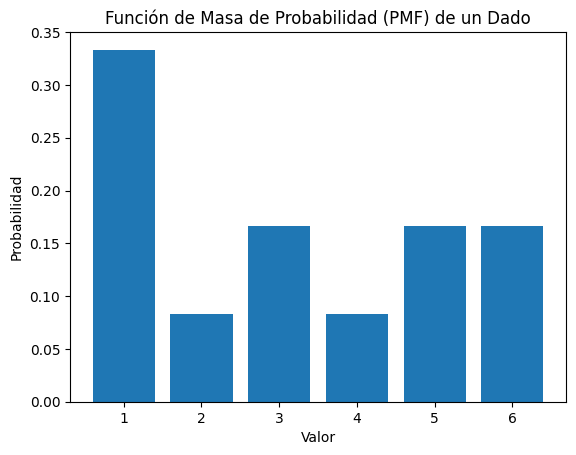

In [45]:
# Definir los valores posibles y sus probabilidades
valores_posibles = [1, 2, 3, 4, 5, 6]
probabilidades = [1/3, 1/12, 1/6, 1/12, 1/6, 1/6]  # Dado trucado en un casino

# Crear un diccionario para representar la PMF
pmf = dict(zip(valores_posibles, probabilidades))

# Calcular la probabilidad de un valor específico
x = 3
probabilidad_x = pmf.get(x, 0)  # 1/6

print(f'P(X = {x}) = {probabilidad_x}')


# Crear un gráfico de barras para la PMF
plt.bar(valores_posibles, probabilidades, tick_label=valores_posibles)

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Probabilidad')
plt.title('Función de Masa de Probabilidad (PMF) de un Dado')

# Mostrar el gráfico
plt.show()


**Función de Densidad de Probabilidad (PDF)**

Se trata de una función matemática que se utiliza en teoría de la probabilidad para describir la distribución de probabilidad de una variable aleatoria continua.


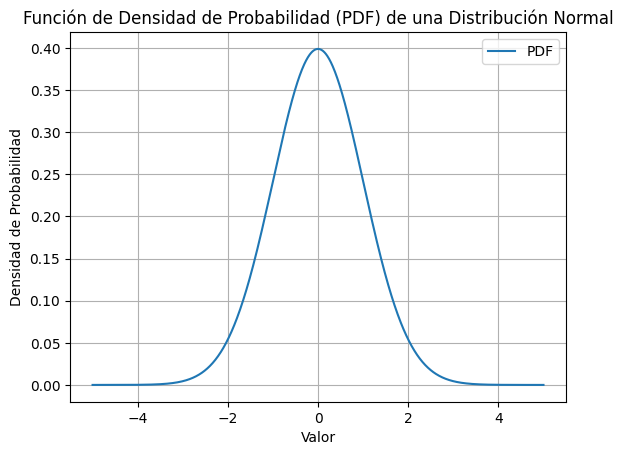

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Generar datos de ejemplo: una distribución normal (gaussiana)
mu = 0  # Media
sigma = 1  # Desviación estándar
x = np.linspace(-5, 5, 1000)  # Valores en el eje x
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu)**2) / (2 * sigma**2))  # PDF de la distribución normal

# Crear un gráfico de la PDF
plt.plot(x, pdf, label='PDF')

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Densidad de Probabilidad')
plt.title('Función de Densidad de Probabilidad (PDF) de una Distribución Normal')

# Mostrar el gráfico
plt.legend()
plt.grid()
plt.show()


**Ejercicio 7:** rellena el código que falta del siguiente código

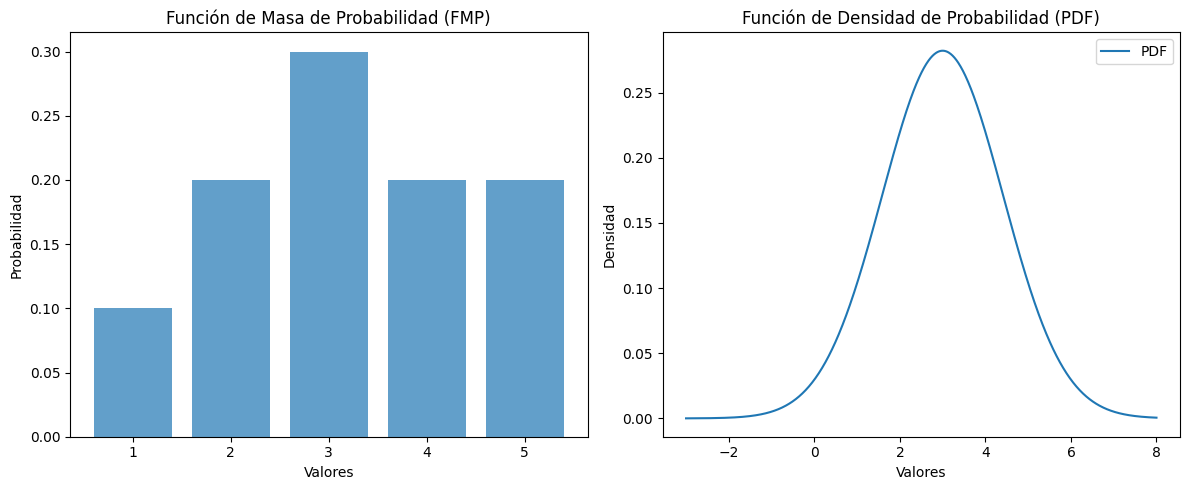

In [49]:
# Voy a completar el código para que represente la relación entre una distribución discreta
# (la distribución representada por valores_A y valores_B) y una distribución normal continua
# (utilizando la función de densidad de probabilidad o PDF).
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # Para la distribución normal

# Distribución discreta
valores_A = [1, 2, 3, 4, 5]
valores_B = [0.1, 0.2, 0.3, 0.2, 0.2]

# Distribución normal (continua)
A = np.mean(valores_A)  # Media
B = np.std(valores_A)   # Desviación estándar
xc = np.linspace(-3, 8, 1000)  # Valores en el eje x para la distribución continua
pdf_continua = norm.pdf(xc, loc=A, scale=B)

# Crear un gráfico que muestra ambas distribuciones
plt.figure(figsize=(12, 5))

# Gráfico de la distribución discreta
plt.subplot(121)
plt.bar(valores_A, valores_B, align='center', alpha=0.7)
plt.xticks(valores_A)
plt.xlabel('Valores')
plt.ylabel('Probabilidad')
plt.title('Función de Masa de Probabilidad (FMP)')

# Gráfico de la distribución normal
plt.subplot(122)
plt.plot(xc, pdf_continua, label='PDF')
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.title('Función de Densidad de Probabilidad (PDF)')
plt.legend()

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()


# **TAREA 2b (Práctica)**
Estimación temporal: 2 horas




**Modelos probabilísticos gráficos: teorema de Bayes y redes bayesianas**

Los problemas que usan grafos pueden modelarse un modelos de dos tipos: las Redes Bayesianas y los Modelos de Markov. Anteriormente se han comentado algunos modelos de Markov, como propagación de creencias. En redes bayesianas hay multitud de clasificaciones y técnicas, adecuadas cada una a un problema concreto.

**Ejercicio 8:** Partimos de un problema particular (el trabajo final).  Imaginemos que el problema es probabilístico y, por tanto, queremos saber como modelarlo.
Vamos a estudiar todas las alternativas que existen, y vamos a **implementar** una **TÉCNICA** que creamos que es correcta para aplicarla al problema (la implementación no tiene que ser sobre el trabajo final, sino en un ejemplo simple, y comentarlo paso a paso).
Finalmente, vamos a estudiar y explicar las diferentes **ESTIMACIONES** de la incertidumbre en redes bayesianas (pág. 49, Tema 3), elegimos una (o varias, si se desea hacer alguna comparativa), explicándola y aplicandola al ejemplo.

La recomendación de productos basada en el filtrado colaborativo se centra en predecir las preferencias de un usuario en función de las preferencias de otros usuarios. Por ejemplo, si Alex y Dani tienen preferencias similares en películas, y Dani le gusta una película que Alex no ha visto, entonces es probable que esa película también le guste a Alex.

**Implementación simple de recomendación usando Redes Bayesianas:**
Para mantenerlo simple, consideremos un pequeño conjunto de datos con usuarios y películas. Cada usuario ha calificado algunas películas en una escala de 1 a 5.

**Modelado del problema:**

**Nodos:** Usuarios, películas y calificaciones.
**Arcos:** Representan las dependencias entre los nodos. Una calificación depende tanto del usuario que la da como de la película que la recibe.
**Estimación de parámetros:** Usaremos un conjunto de datos para estimar las probabilidades en nuestra red. La probabilidad de que un usuario califique una película con un '5' se estima como el número de veces que el usuario dio esa calificación partido por el número total de películas que calificó.
Uso de **intervalos de confianza** para estimar la incertidumbre en nuestras probabilidades calculadas. Por ejemplo, podríamos usar bootstrapping para generar múltiples conjuntos de datos resampleados y calcular las probabilidades para cada uno, y luego usar esos resultados para calcular un intervalo de confianza.

In [50]:
#respuesta
import numpy as np

# Ejemplo de datos (usuarios x películas)
# 0 indica que no se ha calificado la película
ratings = np.array([
    [5, 4, 0, 1],
    [4, 0, 3, 2],
    [0, 4, 5, 0]
])

# Estimar la probabilidad de cada calificación para una película
def estimate_prob(movie_ratings):
    counts = np.bincount(movie_ratings, minlength=6)
    return counts / np.sum(counts)

# Probabilidades por película
movie_probs = [estimate_prob(ratings[:, i][ratings[:, i] > 0]) for i in range(ratings.shape[1])]

print(movie_probs)


[array([0. , 0. , 0. , 0. , 0.5, 0.5]), array([0., 0., 0., 0., 1., 0.]), array([0. , 0. , 0. , 0.5, 0. , 0.5]), array([0. , 0.5, 0.5, 0. , 0. , 0. ])]
